# Business Analysis - Ford GoBike System

##  Investigation Overview

This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. I'm most interested in figuring out what features are best for predicting the business revenue and asset(bike) depreciation by referring to the duration time and distance. In addition, I am also interested in finding marketing points that are likely to improve efficiency and effectiveness in the business. I expect the type of users will have the most potent effect on duration and distance because subscribers are more likely to use the bike than customers along long stretches. I also think this will be variable depending on the day of the week.          

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe, print statistics
df = pd.read_csv('201902-fordgobike-tripdata.csv')

In [3]:
# Convert type into DateTime for start_time and end_time, and extract statistical objects

df['age'] = 2019 - df.member_birth_year  

df['start_time'] = pd.to_datetime(df.start_time)
df['end_time'] = pd.to_datetime(df.end_time)
        
df['check_in_hour'] = pd.to_datetime(df.start_time).dt.time.astype(str).str[:-13]
df['check_in_hour'] = pd.to_numeric(df['check_in_hour'])

df['date'] = pd.to_datetime(df.start_time).dt.date
df['date'] = pd.to_datetime(df.date)
df['day_of_week'] = df['date'].dt.dayofweek # 0: Mon , 5: Sun

In [4]:
# Calculate straight-line distance between start_station and end_station
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0
distance_km = []

for i1, j1, i2, j2 in zip(df['start_station_latitude'], df['start_station_longitude'], df['end_station_latitude'], df['end_station_longitude']):
    lat1 = radians(i1)
    lon1 = radians(j1)
    lat2 = radians(i2)
    lon2 = radians(j2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    distance_km.append(distance)
    
df['distance_km'] = distance_km

In [5]:
# categorize 'StartToEnd' column per each kilometer into 'ReturnPoint' column

df.loc[df['distance_km'] == 0, 'ReturnPoint'] = '0km'
df.loc[df['distance_km'] > 0, 'ReturnPoint'] = '0~1km away'
df.loc[df['distance_km'] >= 1, 'ReturnPoint'] = '1~2km away'
df.loc[df['distance_km'] >= 2, 'ReturnPoint'] = '2~3km away'
df.loc[df['distance_km'] >= 3, 'ReturnPoint'] = '3~4km away'
df.loc[df['distance_km'] >= 4, 'ReturnPoint'] = '4~5km away'
df.loc[df['distance_km'] >= 5, 'ReturnPoint'] = '5~ km away'

In [6]:
# convert object types into ordered categorical types

start_station_name = df.start_station_name.value_counts().index.values
end_station_name = df.end_station_name.value_counts().index.values
user_type = df.user_type.value_counts().index.values
member_gender = df.member_gender.value_counts().index.values
bike_share_for_all_trip = df.bike_share_for_all_trip.value_counts().index.values

ordinal_var_dict = {'start_station_name': start_station_name,
                    'end_station_name': end_station_name,
                    'user_type': user_type,
                    'member_gender': member_gender,
                    'bike_share_for_all_trip': bike_share_for_all_trip}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)
    
df = df.sort_values('ReturnPoint')
print(df.dtypes)    

duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                  float64
start_station_name               category
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_name                 category
end_station_latitude              float64
end_station_longitude             float64
bike_id                             int64
user_type                        category
member_birth_year                 float64
member_gender                    category
bike_share_for_all_trip          category
age                               float64
check_in_hour                     float64
date                       datetime64[ns]
day_of_week                         int64
distance_km                       float64
ReturnPoint                        object
dtype: object


In [7]:
# font to use in Slide Deck

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

default_color = sb.color_palette()[0]

In [8]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,age,check_in_hour,date,day_of_week,distance_km,ReturnPoint
11140,175,2019-02-27 19:05:47.640,2019-02-27 19:08:43.230,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,3.0,Powell St BART Station (Market St at 4th St),37.786375,...,Subscriber,1999.0,Male,No,20.0,19.0,2019-02-27,2,0.0,0km
62654,1721,2019-02-20 16:17:26.805,2019-02-20 16:46:08.725,33.0,Golden Gate Ave at Hyde St,37.781650,-122.415408,33.0,Golden Gate Ave at Hyde St,37.781650,...,Subscriber,1989.0,Male,No,30.0,16.0,2019-02-20,2,0.0,0km
128288,1904,2019-02-10 13:14:56.197,2019-02-10 13:46:40.970,27.0,Beale St at Harrison St,37.788059,-122.391865,27.0,Beale St at Harrison St,37.788059,...,Subscriber,1984.0,Male,No,35.0,13.0,2019-02-10,6,0.0,0km
95346,203,2019-02-15 14:06:50.637,2019-02-15 14:10:14.292,11.0,Davis St at Jackson St,37.797280,-122.398436,11.0,Davis St at Jackson St,37.797280,...,Subscriber,1982.0,Male,No,37.0,14.0,2019-02-15,4,0.0,0km
95370,1609,2019-02-15 13:39:46.230,2019-02-15 14:06:35.404,240.0,Haste St at Telegraph Ave,37.866043,-122.258804,240.0,Haste St at Telegraph Ave,37.866043,...,Subscriber,1988.0,Male,No,31.0,13.0,2019-02-15,4,0.0,0km


In [9]:
# high-level overview of data shape and composition
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183412 entries, 11140 to 146778
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             183412 non-null  int64         
 1   start_time               183412 non-null  datetime64[ns]
 2   end_time                 183412 non-null  datetime64[ns]
 3   start_station_id         183215 non-null  float64       
 4   start_station_name       183215 non-null  category      
 5   start_station_latitude   183412 non-null  float64       
 6   start_station_longitude  183412 non-null  float64       
 7   end_station_id           183215 non-null  float64       
 8   end_station_name         183215 non-null  category      
 9   end_station_latitude     183412 non-null  float64       
 10  end_station_longitude    183412 non-null  float64       
 11  bike_id                  183412 non-null  int64         
 12  user_type   

In [10]:
# descriptive statistics for numeric variables
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,age,check_in_hour,day_of_week,distance_km
count,183412.000000,183215.000000,183412.000000,183412.000000,183215.000000,183412.000000,183412.000000,183412.000000,175147.000000,175147.000000,183266.000000,183412.000000,183412.000000
mean,726.078435,138.590427,37.771223,-122.352664,136.249123,37.771427,-122.352250,4472.906375,1984.806437,34.193563,13.458066,2.632178,1.691190
std,1794.389780,111.778864,0.099581,0.117097,111.515131,0.099490,0.116673,1664.383394,10.116689,10.116689,4.725155,1.814786,1.097934
min,61.000000,3.000000,37.317298,-122.453704,3.000000,37.317298,-122.453704,11.000000,1878.000000,18.000000,0.000000,0.000000,0.000000
25%,325.000000,47.000000,37.770083,-122.412408,44.000000,37.770407,-122.411726,3777.000000,1980.000000,27.000000,9.000000,1.000000,0.911241
50%,514.000000,104.000000,37.780760,-122.398285,100.000000,37.781010,-122.398279,4958.000000,1987.000000,32.000000,14.000000,3.000000,1.431187
75%,796.000000,239.000000,37.797280,-122.286533,235.000000,37.797320,-122.288045,5502.000000,1992.000000,39.000000,17.000000,4.000000,2.226386
max,85444.000000,398.000000,37.880222,-121.874119,398.000000,37.880222,-121.874119,6645.000000,2001.000000,141.000000,23.000000,6.000000,69.491049


In [11]:
df.head(10)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,user_type,member_birth_year,member_gender,bike_share_for_all_trip,age,check_in_hour,date,day_of_week,distance_km,ReturnPoint
11140,175,2019-02-27 19:05:47.640,2019-02-27 19:08:43.230,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,3.0,Powell St BART Station (Market St at 4th St),37.786375,...,Subscriber,1999.0,Male,No,20.0,19.0,2019-02-27,2,0.0,0km
62654,1721,2019-02-20 16:17:26.805,2019-02-20 16:46:08.725,33.0,Golden Gate Ave at Hyde St,37.781650,-122.415408,33.0,Golden Gate Ave at Hyde St,37.781650,...,Subscriber,1989.0,Male,No,30.0,16.0,2019-02-20,2,0.0,0km
128288,1904,2019-02-10 13:14:56.197,2019-02-10 13:46:40.970,27.0,Beale St at Harrison St,37.788059,-122.391865,27.0,Beale St at Harrison St,37.788059,...,Subscriber,1984.0,Male,No,35.0,13.0,2019-02-10,6,0.0,0km
95346,203,2019-02-15 14:06:50.637,2019-02-15 14:10:14.292,11.0,Davis St at Jackson St,37.797280,-122.398436,11.0,Davis St at Jackson St,37.797280,...,Subscriber,1982.0,Male,No,37.0,14.0,2019-02-15,4,0.0,0km
95370,1609,2019-02-15 13:39:46.230,2019-02-15 14:06:35.404,240.0,Haste St at Telegraph Ave,37.866043,-122.258804,240.0,Haste St at Telegraph Ave,37.866043,...,Subscriber,1988.0,Male,No,31.0,13.0,2019-02-15,4,0.0,0km
37141,676,2019-02-23 14:40:17.266,2019-02-23 14:51:33.867,377.0,Fell St at Stanyan St,37.771917,-122.453704,377.0,Fell St at Stanyan St,37.771917,...,Subscriber,1981.0,Female,No,38.0,14.0,2019-02-23,5,0.0,0km
37142,674,2019-02-23 14:40:13.892,2019-02-23 14:51:28.510,377.0,Fell St at Stanyan St,37.771917,-122.453704,377.0,Fell St at Stanyan St,37.771917,...,Subscriber,1982.0,Male,No,37.0,14.0,2019-02-23,5,0.0,0km
128257,344,2019-02-10 13:44:44.674,2019-02-10 13:50:28.977,377.0,Fell St at Stanyan St,37.771917,-122.453704,377.0,Fell St at Stanyan St,37.771917,...,Subscriber,1984.0,Male,No,35.0,13.0,2019-02-10,6,0.0,0km
6206,963,2019-02-28 10:39:53.249,2019-02-28 10:55:56.609,262.0,West St at University Ave,37.869967,-122.286533,262.0,West St at University Ave,37.869967,...,Customer,NaN,NaN,No,NaN,10.0,2019-02-28,3,0.0,0km
95401,962,2019-02-15 13:44:33.549,2019-02-15 14:00:36.411,13.0,Commercial St at Montgomery St,37.794231,-122.402923,13.0,Commercial St at Montgomery St,37.794231,...,Subscriber,1974.0,Male,Yes,45.0,13.0,2019-02-15,4,0.0,0km


In [12]:
df.ReturnPoint.value_counts()

1~2km away    72241
0~1km away    50511
2~3km away    34516
3~4km away    15219
4~5km away     5035
0km            3880
5~ km away     2010
Name: ReturnPoint, dtype: int64

In [13]:
df.member_birth_year.describe()

count    175147.000000
mean       1984.806437
std          10.116689
min        1878.000000
25%        1980.000000
50%        1987.000000
75%        1992.000000
max        2001.000000
Name: member_birth_year, dtype: float64

## Dataset Overview

There are 183,412 unique bike_Id numbers in the dataset with 21 features (`duration_sec`, `start_time`, `end_time`, `start_station_id`, `start_station_name`, `start_station_latitude`, `start_station_longitude`, `end_station_id`, `end_station_name`, `end_station_latitude`, `end_station_longitude`, `bike_id, user_type`, `member_birth_year`, `member_gender`, `bike_share_for_all_trip`, `check_in_hour, date`, `day_of_week`, `distance_km`, and, `ReturnPoint`). Most variables are numeric in nature, but the variables `user_type`, `member_gender`, `bike_share_for_all_trip`, `check_in_hour`, `day_of_week`, `ReturnPoint`, `member_birth_year` are categorical variables with the following levels.

- user_type: Subscriber, Customer 

- member_gender: Male, Female (or vice versa)

- bike_share_for_all_trip: Yes, No

- check_in_hour: 0 ~ 23

- day_of_week: 0(Mon) ~ 6(Sun)

- member_birth_year: 1878 ~ 2001(Year)

- ReturnPoint: 0(km), 0 ~ 1(km), 1 ~ 2(km), 2 ~ 3(km), 3 ~ 4(km), 4 ~ 5(km), 5 ~(km)

Note) `member_birth_year` and `day_of_week` are also applied both variables for investigation purposes. 


## Executive summary

Most of the stations are located in three densely populated zones around San Francisco Bay. I assume that the primary purpose of using the bike is commuting from home to the office or neighborhood shopping, which is not just for exercise. Duration forms almost standard distribution, where the average time is about 12.1 minutes. This could possibly mean that my initial assumption on the purpose of use is correct. Because the average use time is less than 10 minutes, proportionally, the average distance is 1.69 kilometers. Most users park the bike where 1 to 2 kilometers away from the initial station. About 2.1% of checked-in users did not use the bike. Interestingly, non-subscribers used longer distances than subscribers, and so do those who do not use the bike-sharing services during the entire trip. Subscribers are almost eight times as many as non-subscribers, and those are mostly male who is not sharing the bike during their entire trip. The duration per member's birth year forms a normal distribution to the 8.6-minute point; however, the distance plot is skewed to the left. This possibly explains that the age group between mid-'20s and mid-'30s are remarkable active users.

Most of the stations are located in three densely populated zones around San Francisco Bay. I assume that the primary purpose of using the bike is commuting from home to the office or neighborhood shopping, which is not just for exercise.

In [14]:
import folium

lat = df.start_station_latitude.mean()
long = df.start_station_longitude.mean()

m = folium.Map(location=[lat, long], zoom_start = 9)

for i in df.index[:500]:
    tooltip = df.loc[i,"start_station_name"]
    lat = df.loc[i,"start_station_latitude"]
    long = df.loc[i,"start_station_longitude"]
    
    folium.Marker([lat, long], tooltip = tooltip).add_to(m) 
    
for i in df.index[:500]:
    tooltip = df.loc[i,"end_station_name"]
    lat = df.loc[i,"end_station_latitude"]
    long = df.loc[i,"end_station_longitude"]

folium.Marker([lat, long], tooltip = tooltip).add_to(m) 

m
       

In [15]:
print('< Top 10 Station Address >')
print('\n')
print(df.start_station_name.value_counts()[0:10])

< Top 10 Station Address >


Market St at 10th St                                         3904
San Francisco Caltrain Station 2  (Townsend St at 4th St)    3544
Berry St at 4th St                                           3052
Montgomery St BART Station (Market St at 2nd St)             2895
Powell St BART Station (Market St at 4th St)                 2760
San Francisco Ferry Building (Harry Bridges Plaza)           2710
San Francisco Caltrain (Townsend St at 4th St)               2703
Powell St BART Station (Market St at 5th St)                 2327
Howard St at Beale St                                        2293
Steuart St at Market St                                      2283
Name: start_station_name, dtype: int64


In [16]:
np.log10(df.duration_sec.describe())

count    5.263428
mean     2.860984
std      3.253917
min      1.785330
25%      2.511883
50%      2.710963
75%      2.900913
max      4.931682
Name: duration_sec, dtype: float64

In [17]:
df.duration_sec.describe()

count    183412.000000
mean        726.078435
std        1794.389780
min          61.000000
25%         325.000000
50%         514.000000
75%         796.000000
max       85444.000000
Name: duration_sec, dtype: float64

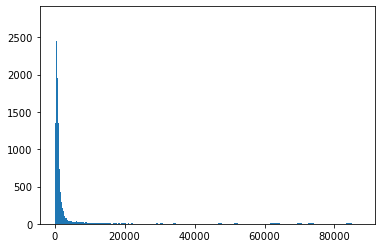

In [18]:
bins = 10 ** np.arange(1.78, 4.94 +0.01, 0.01)
plt.hist(data = df, x = 'duration_sec', bins = bins);

##  Distribution of Duration (minute)

Duration forms almost standard distribution, where the average time is about 12.1 minutes. This could possibly mean that my initial assumption on the purpose of use is correct.

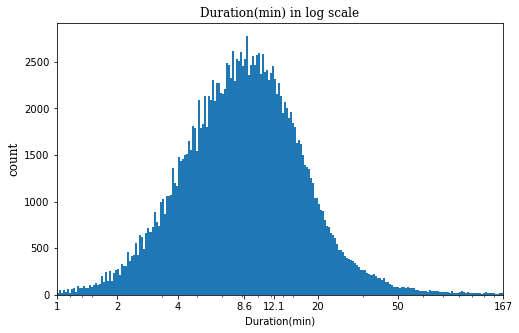

In [19]:
plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'duration_sec', bins = bins);
plt.xscale('log')
plt.xticks([60, 120, 240, 514, 726, 1200, 3000, 10000], [1, 2, 4, 8.6, 12.1, 20, 50, 167]);
plt.xlabel('Duration(min)');
plt.ylabel('count', fontdict = font);
plt.xlim(60, 10000);
plt.title('Duration(min) in log scale', fontdict = font);

In [20]:
np.log10(df.distance_km.describe())

C:\Users\aicpa\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


count    5.263428
mean     0.228192
std      0.040576
min          -inf
25%     -0.040367
50%      0.155696
75%      0.347600
max      1.841929
Name: distance_km, dtype: float64

In [21]:
df.distance_km.describe()

count    183412.000000
mean          1.691190
std           1.097934
min           0.000000
25%           0.911241
50%           1.431187
75%           2.226386
max          69.491049
Name: distance_km, dtype: float64

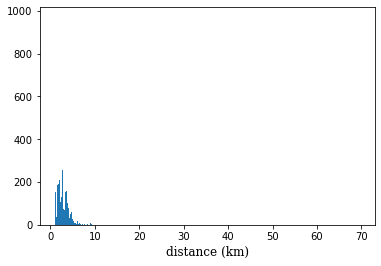

In [22]:
bins = 10 ** np.arange(0, 1.842 +0.001, 0.001)
plt.hist(data = df, x = 'distance_km', bins = bins);
plt.xlabel('distance (km)', fontdict = font);

##  Distribution of Distance (km)
Because the average use time is less than 10 minutes, proportionally, the average distance is 1.69 kilometers with a long-tailed distribution skewed to the right.

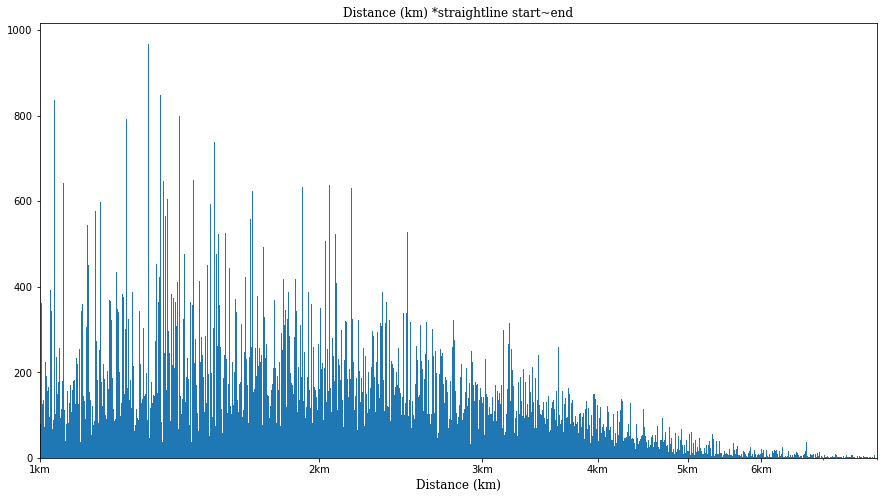

In [23]:
plt.figure(figsize=[15, 8])
plt.hist(data = df, x = 'distance_km', bins = bins);
plt.xscale('log')
plt.xlim(1, 8)

plt.xticks([1,2,3,4,5,6], ['1km','2km','3km','4km','5km','6km'])
plt.xlabel('Distance (km)', fontdict = font);
plt.title('Distance (km) *straightline start~end', fontdict = font)

plt.show()

In [24]:
df.distance_km.mean()

1.6911897441564132

## Distribution of End-station
Most users park the bike where 1 to 2 kilometers away from the initial station. About 2.1% of checked-in users did not use the bike.

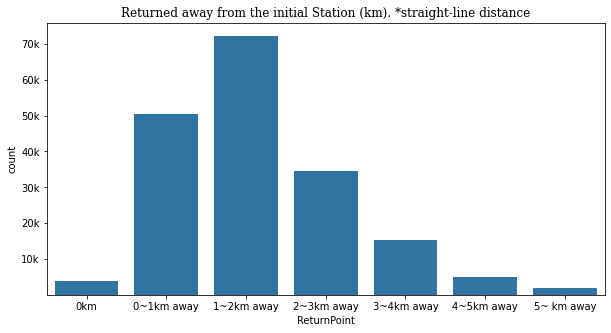

In [25]:
plt.figure(figsize = (10,5))

sb.countplot(data = df, x = 'ReturnPoint', color = default_color)
plt.title('Returned away from the initial Station (km). *straight-line distance', fontdict = font)
plt.yticks([10000,20000,30000,40000,50000,60000,70000], ['10k','20k','30k','40k','50k','60k','70k'])

plt.show()

In [26]:
df.query('ReturnPoint == "0km"').bike_id.count()

3880

In [27]:
df.query('ReturnPoint == "0km"').bike_id.count() / df.shape[0] * 100

2.1154559134625868

## Distribution of other variables

Subscribers are almost eight times as many as non-subscribers, and those are mostly male who is not sharing the bike during their entire trip.

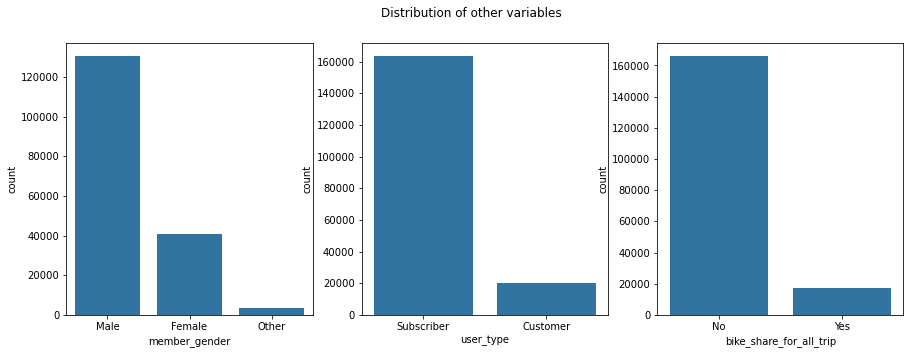

In [28]:
# let's plot all three together to get an idea of each ordinal variable's distribution.

fig, ax = plt.subplots(ncols=3, figsize = [15,5])

sb.countplot(data = df, x = 'member_gender', color = default_color, ax = ax[0])
sb.countplot(data = df, x = 'user_type', color = default_color, ax = ax[1])
sb.countplot(data = df, x = 'bike_share_for_all_trip', color = default_color, ax = ax[2])

fig.suptitle('Distribution of other variables');

plt.show()

User's age is distributed mainly between late 20's and early '30s and, and they mostly used the bike during the commuting hours. There were more users during weekdays than weekends. The highest demand day and the lowest demand day are on Thursday and Saturday, respectively, showing a bimodal pattern.

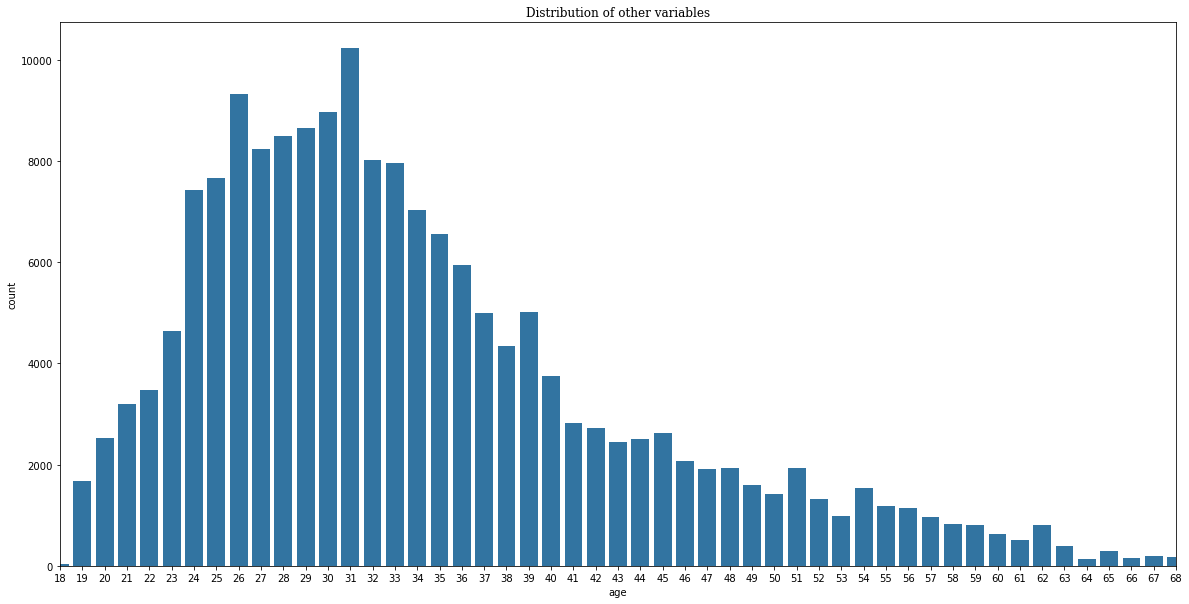

In [29]:
plt.figure(figsize = [20,10])
sb.countplot(data = df, x = 'age', color = default_color) 
plt.xticks(range(0,112,1), range(18,130,1))
plt.xlim(0,50)
plt.title('Distribution of other variables', fontdict = font, loc = 'center')

plt.show()

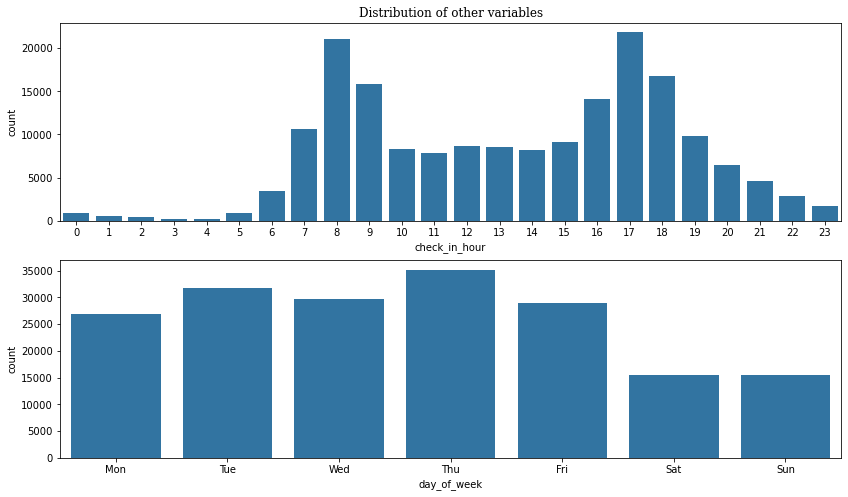

In [30]:
# let's plot all three together to get an idea of each ordinal variable's distribution.
plt.figure(figsize = [14,8])

plt.subplot(2,1,1)

plt.title('Distribution of other variables', fontdict = font, loc = 'center')

sb.countplot(data = df, x = 'check_in_hour', color = default_color)
plt.xticks(range(0,24,1), range(0,24,1))

plt.subplot(2,1,2)
sb.countplot(data = df, x = 'day_of_week', color = default_color)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])


plt.show()

Most users used the bike during commuting hours regardless of gender, user types, bike-sharing, and weekdays. However, users checked in around noon during the weekends. 

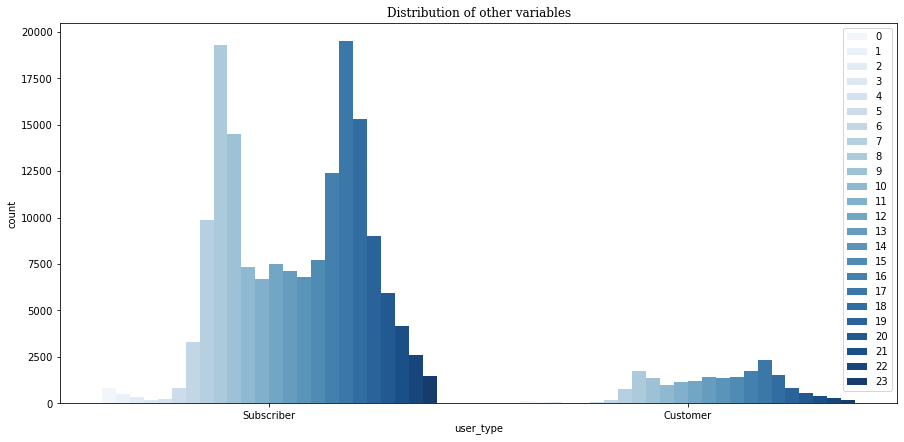

In [31]:
plt.figure(figsize = [15, 7])
labels = np.arange(0,24,1)

ax = sb.countplot(data = df, x = 'user_type', hue = 'check_in_hour', palette = 'Blues')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, labels, bbox_to_anchor=(1,1))
plt.title('Distribution of other variables', fontdict = font, loc = 'center')

plt.show()

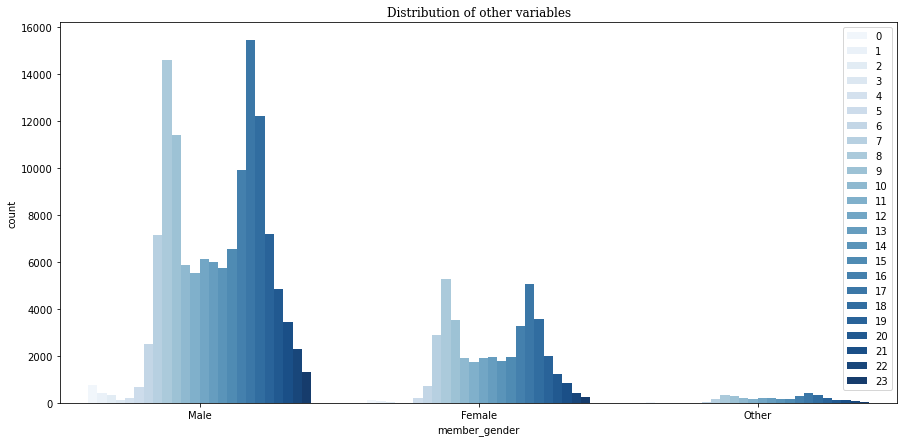

In [32]:
plt.figure(figsize = [15, 7])
labels = np.arange(0,24,1)

ax = sb.countplot(data = df, x = 'member_gender', hue = 'check_in_hour', palette = 'Blues')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, labels, bbox_to_anchor=(1,1))
plt.title('Distribution of other variables', fontdict = font, loc = 'center')

plt.show()

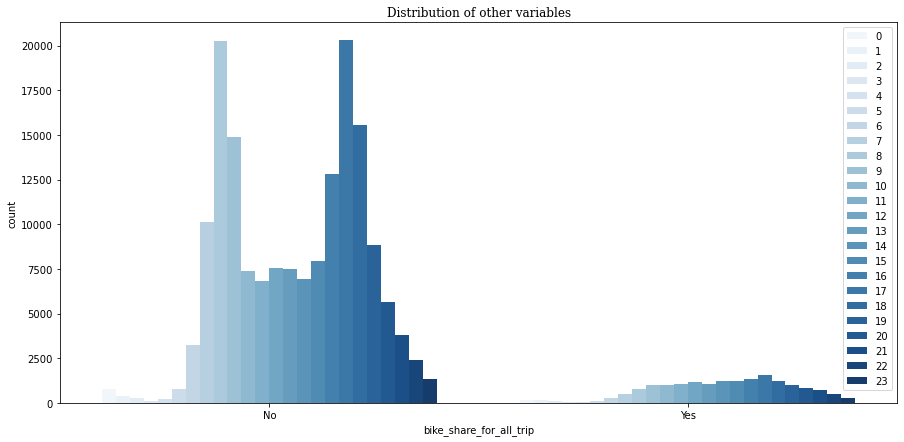

In [33]:
plt.figure(figsize = [15, 7])
labels = np.arange(0,24,1)

ax = sb.countplot(data = df, x = 'bike_share_for_all_trip', hue = 'check_in_hour', palette = 'Blues')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, labels, bbox_to_anchor=(1,1))
plt.title('Distribution of other variables', fontdict = font, loc = 'center')

plt.show()

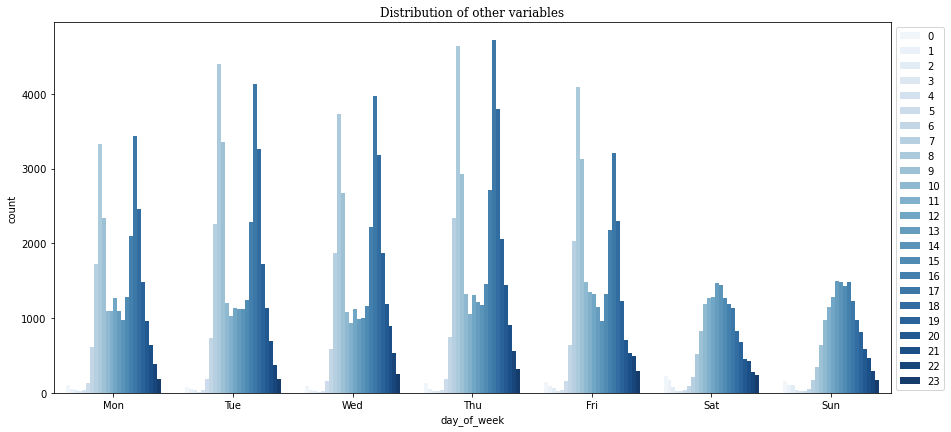

In [34]:
plt.figure(figsize = [15, 15])
labels = np.arange(0,24,1)

plt.subplot(2,1,2)
ax = sb.countplot(data = df, x = 'day_of_week', hue = 'check_in_hour', palette = 'Blues')
legend_labels, _= ax.get_legend_handles_labels()
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.legend(legend_labels, labels, bbox_to_anchor=(1,1))
plt.title('Distribution of other variables', fontdict = font, loc = 'center')

plt.show()

In [35]:
# 'check_in_hour', 'day_of_week' are added to check if it has a pattern. 
numeric_vars = ['duration_sec', 'member_birth_year', 'check_in_hour', 'day_of_week', 'distance_km'] 

categoric_vars = ['user_type', 'member_gender', 'check_in_hour', 'day_of_week','bike_share_for_all_trip', 'ReturnPoint']

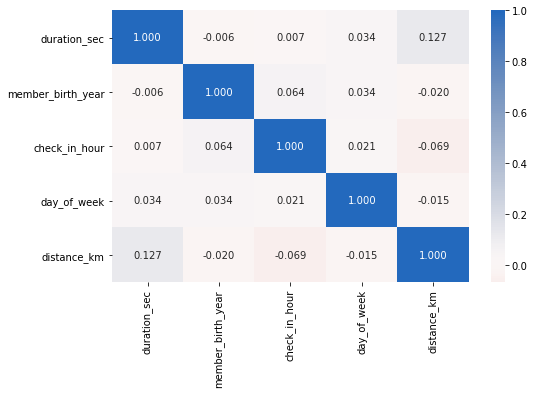

In [36]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

The younger the users are, the more diverse duration of use exists, and we can also find that the distance is not proportional to the duration, which provides evidence that only because the duration is long, it does not necessarily require that we need to increase this into the depreciation factor. 

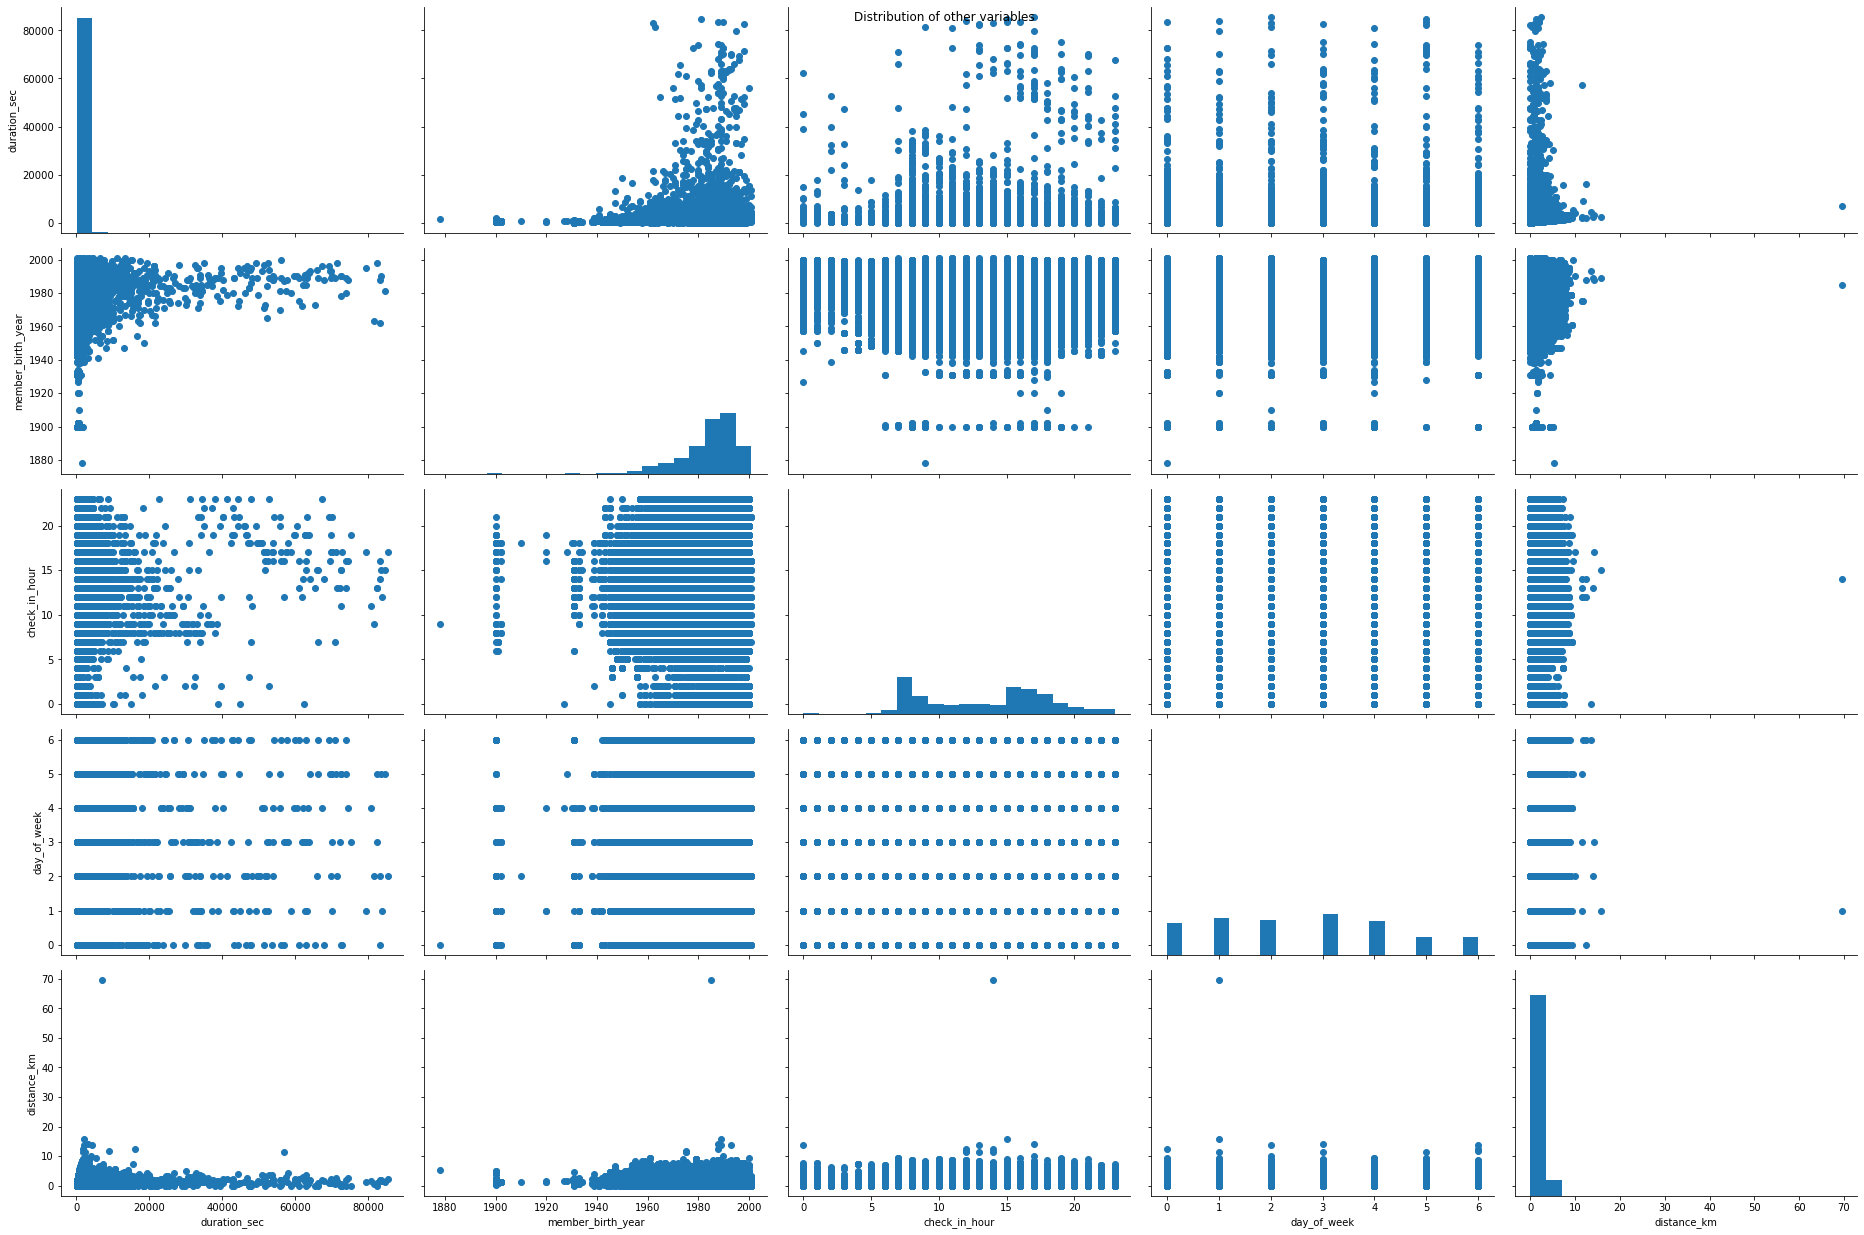

In [37]:
g = sb.PairGrid(data = df, vars = numeric_vars, height=3.5, aspect=1.5);
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter);

g.fig.suptitle('Distribution of other variables');

plt.show();

## Duration vs User type, Day of week, and Check in hour

Interestingly, the subscribers less used the bike than non-subscribers, which is probably a vital marketing point because we can increase the profit margin, revenue minus cost, with the membership contract. Although we figured out there are fewer users during the weekends, but they used more time. With these findings, we possibly recommend last-In bikes(high-tier inventory) to first-Out(serve) to weekend users with premium memberships. 

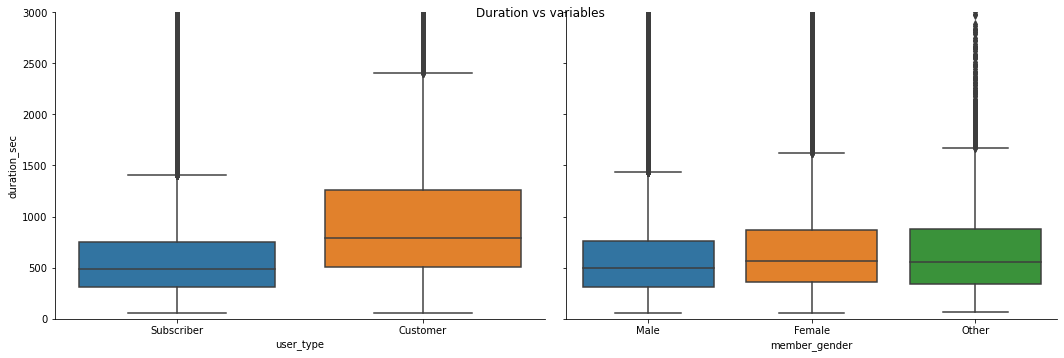

In [38]:
def boxgrid(x, y, **kwargs):
    sb.boxplot(x, y)
    plt.ylim(0,3000)

g = sb.PairGrid(data = df, y_vars = ['duration_sec'], x_vars = categoric_vars[0:2], height = 5, aspect = 1.5)
g.map(boxgrid)
g.fig.suptitle('Duration vs variables');

plt.show();

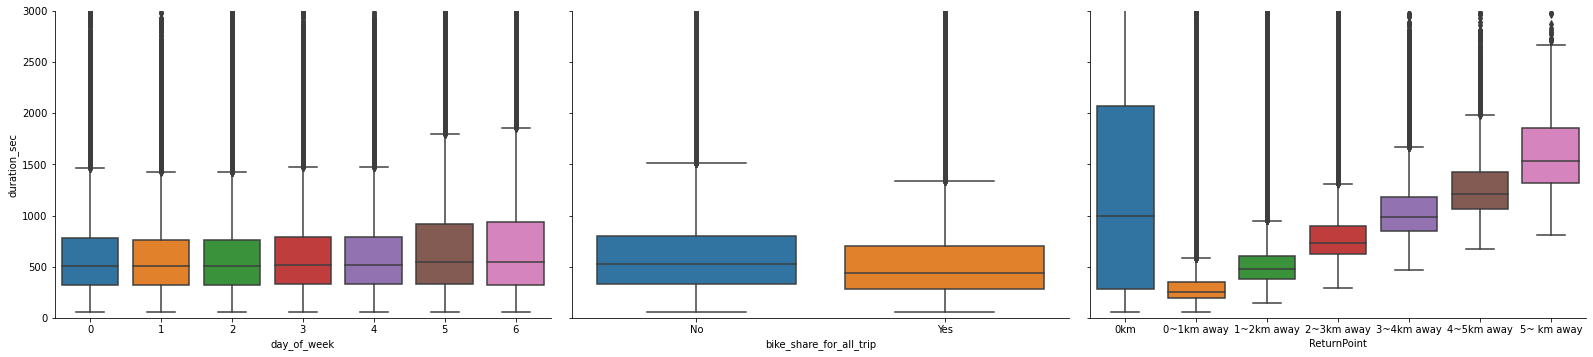

In [39]:
def boxgrid(x, y, **kwargs):
    sb.boxplot(x, y)
    plt.ylim(0,3000)


g = sb.PairGrid(data = df, y_vars = ['duration_sec'], x_vars = categoric_vars[3:6], height = 5, aspect = 1.5)
g.map(boxgrid)
fig.suptitle('Duration vs variables');

plt.show();

Subscribers used the bike 4 to 5 minutes less than customers, and most used the bike for about 10 to 11 minutes, which means they live with a specific daily routine. Because weekdays users have more distinctive diamond shapes on the plot, we can assume that subscribers usually use the bike during the weekdays. In addition, users who checked in at 6 in the morning would be faithful clients because they already got used to commuting by bike. 

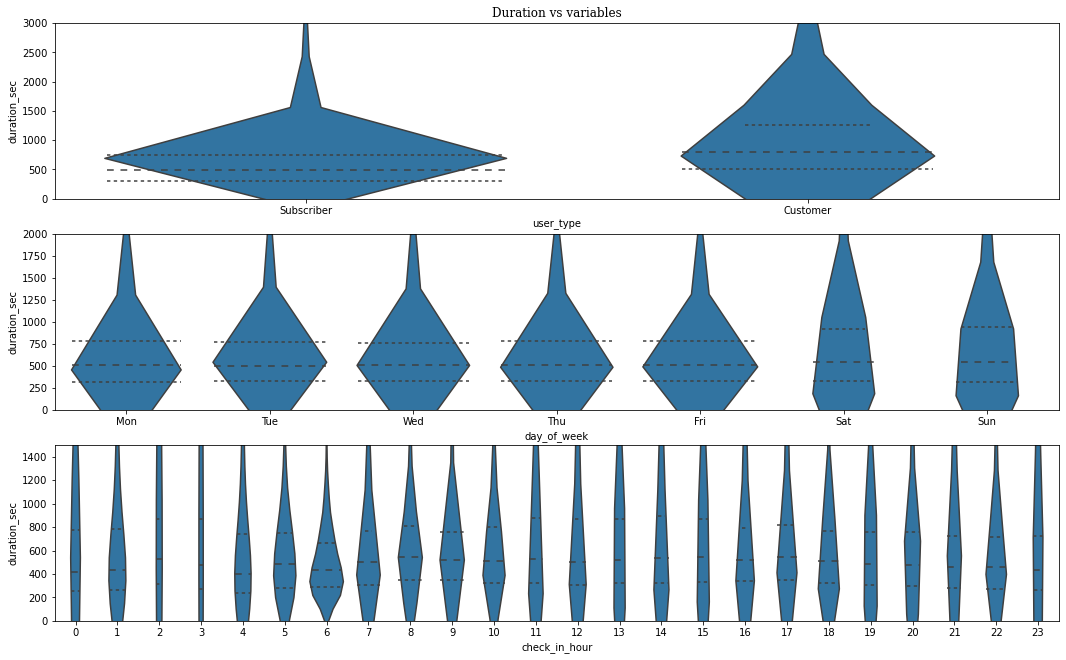

In [40]:
plt.figure(figsize = [18, 11])

plt.subplot(3,1,1)

plt.title('Duration vs variables', fontdict = font, loc = 'center');
sb.violinplot(data = df, x = 'user_type', y = 'duration_sec', inner= 'quartile', color = default_color)
plt.ylim(0,3000)

plt.subplot(3,1,2)
sb.violinplot(data = df, x = 'day_of_week', y = 'duration_sec', inner= 'quartile', color = default_color)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylim(0,2000)

plt.subplot(3,1,3)
sb.violinplot(data = df, x = 'check_in_hour', y = 'duration_sec', inner= 'quartile', color = default_color)
plt.xticks(range(0,24,1), range(0,24,1))
plt.ylim(0,1500)


plt.show()

As we predicted, most subscribers used the bike during the weekdays. 

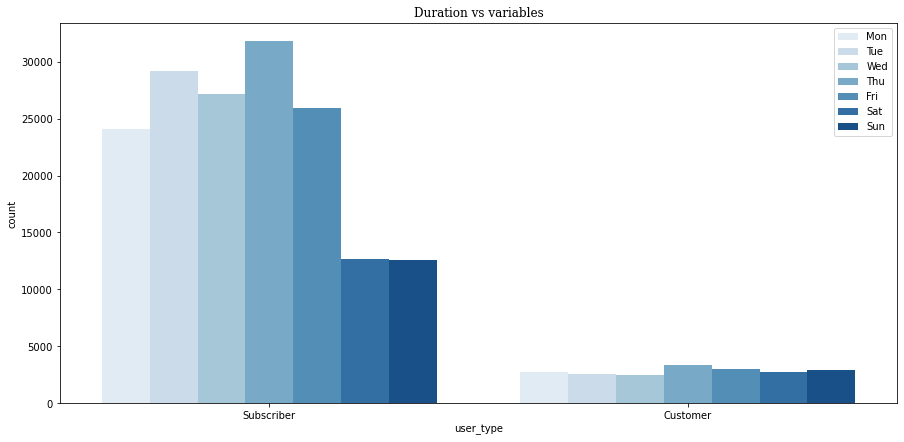

In [41]:
plt.figure(figsize = [15, 7])
ax = sb.countplot(data = df, x = 'user_type', hue = 'day_of_week', palette = 'Blues')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], bbox_to_anchor=(1,1))
plt.title('Duration vs variables', fontdict = font, loc = 'center');
plt.show();

## Distance vs User type, Check in hour, and Bike share during the entire trip

Interestingly, non-subscribers used longer distances than subscribers, and so do those who do not use the bike-sharing services during the entire trip.

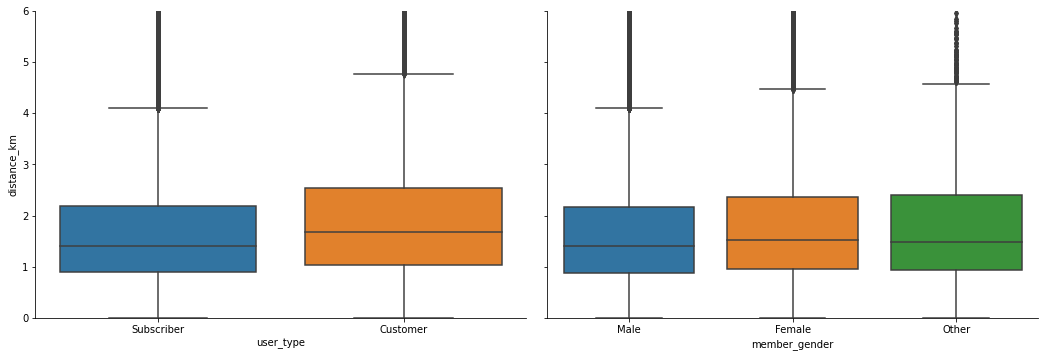

In [42]:
def boxgrid(x, y, **kwargs):
    sb.boxplot(x, y)
    plt.ylim(0,3000)

g = sb.PairGrid(data = df, y_vars = ['distance_km'], x_vars = categoric_vars[0:2], height = 5, aspect = 1.5)
g.map(boxgrid)
plt.ylim(0,6)
fig.suptitle('Distance vs variables');
plt.show();

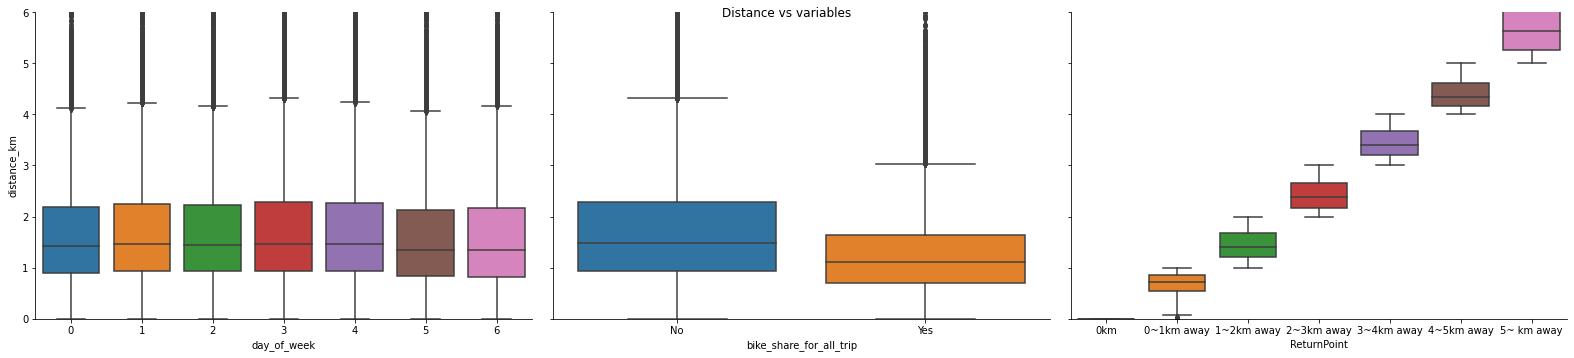

In [43]:
# samples = np.random.choice(df.shape[0], 5000, replace = False)
# df_samp = df.loc[samples,:]

def boxgrid(x, y, **kwargs):
    sb.boxplot(x, y)
    plt.ylim(0,3000)

g = sb.PairGrid(data = df, y_vars = ['distance_km'], x_vars = categoric_vars[3:6], height = 5, aspect = 1.5)
g.map(boxgrid)
plt.ylim(0,6)

g.fig.suptitle('Distance vs variables');

plt.show();

Users who checked in between 7 a.m. and 8 a.m. drove the bike the longest distance, and most of them are non-subscribers. 

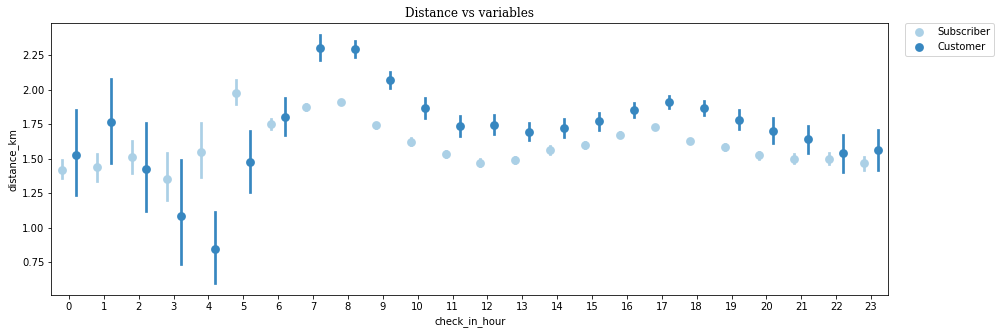

In [44]:
plt.figure(figsize = [15,5])

sb.pointplot(data = df, x = 'check_in_hour', y = 'distance_km', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.xticks(range(0,24,1), range(0,24,1))
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)

plt.title('Distance vs variables', fontdict = font, loc = 'center');

plt.show()

Non-subscribers used the bike about 200 meters shorter than subscribers, and those who do not use bike-sharing services during the entire trip used the bike 400 meters shorter than those who use the bike during the whole trip. In addition, users who checked in at 4 in the morning used the bike in the shortest distance, whereas users who checked in at 5 in the morning and used the bike above the average distance.

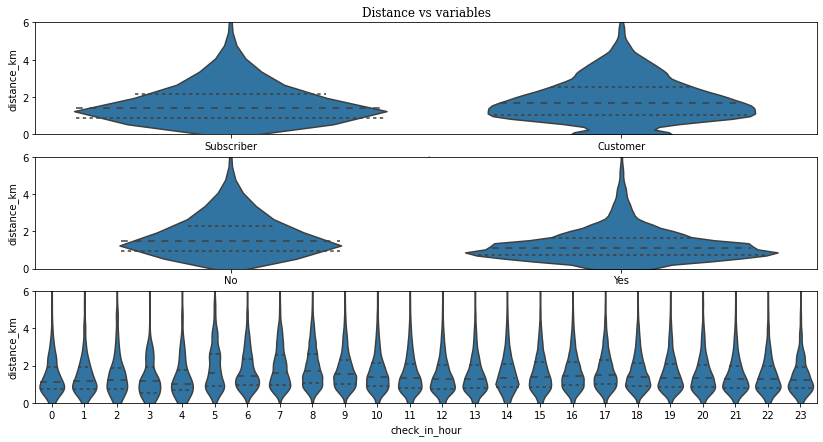

In [45]:
plt.figure(figsize = [14, 7])

plt.subplot(3,1,1)

plt.title('Distance vs variables', fontdict = font, loc = 'center');
sb.violinplot(data = df, x = 'user_type', y = 'distance_km', inner= 'quartile', color = default_color)
plt.ylim(0,6)

plt.subplot(3,1,2)
sb.violinplot(data = df, x = 'bike_share_for_all_trip', y = 'distance_km', inner= 'quartile', color = default_color)
plt.ylim(0,6)

plt.subplot(3,1,3)
sb.violinplot(data = df, x = 'check_in_hour', y = 'distance_km', inner= 'quartile', color = default_color)
plt.xticks(range(0,24,1), range(0,24,1))
plt.ylim(0,6)

plt.show()

In [46]:
df.groupby('user_type').distance_km.mean()

user_type
Subscriber    1.669735
Customer      1.867792
Name: distance_km, dtype: float64

In [47]:
df.groupby('bike_share_for_all_trip').distance_km.mean()

bike_share_for_all_trip
No     1.731565
Yes    1.304968
Name: distance_km, dtype: float64

In [48]:
df.distance_km.mean()

1.6911897441564132

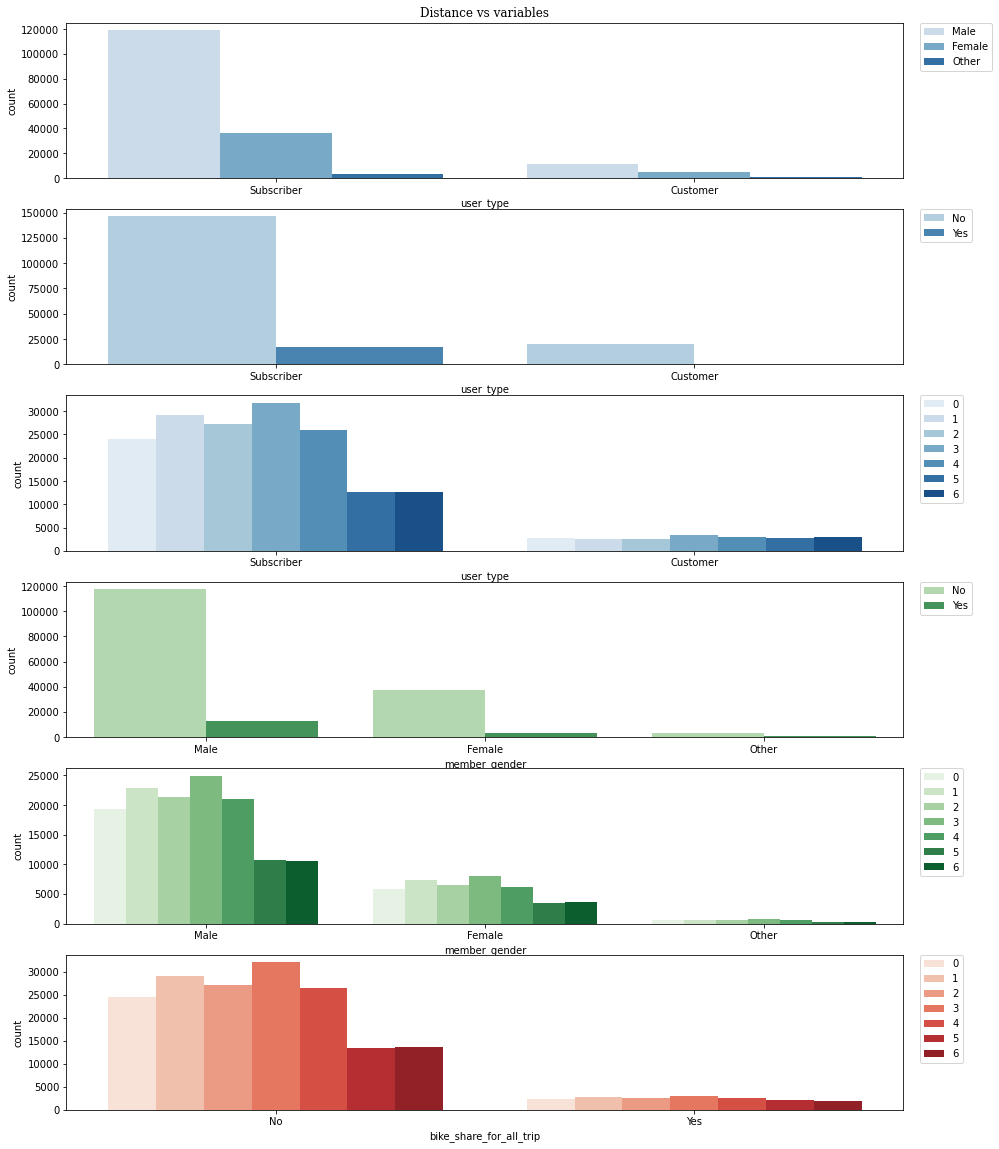

In [49]:
plt.figure(figsize = [15, 20])


plt.subplot(6, 1, 1)

plt.title('Distance vs variables', fontdict = font, loc = 'center');
sb.countplot(data = df, x = 'user_type', hue = 'member_gender', palette = 'Blues')
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)

plt.subplot(6, 1, 2)
sb.countplot(data = df, x = 'user_type', hue = 'bike_share_for_all_trip', palette = 'Blues')
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)

plt.subplot(6, 1, 3)
sb.countplot(data = df, x = 'user_type', hue = 'day_of_week', palette = 'Blues')
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)


plt.subplot(6, 1, 4)
sb.countplot(data = df, x = 'member_gender', hue = 'bike_share_for_all_trip', palette = 'Greens')
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)

plt.subplot(6, 1, 5)
sb.countplot(data = df, x = 'member_gender', hue = 'day_of_week', palette = 'Greens')
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)


plt.subplot(6, 1, 6)
sb.countplot(data = df, x = 'bike_share_for_all_trip', hue = 'day_of_week', palette = 'Reds')
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)

plt.show()

## Distance and Duration vs Member Birth Year

The duration per member's birth year forms a normal distribution to the 8.6-minute point; however, the distance plot is skewed to the left. This possibly explains that the age group between mid-'20s and mid-'30s are remarkable active users. 

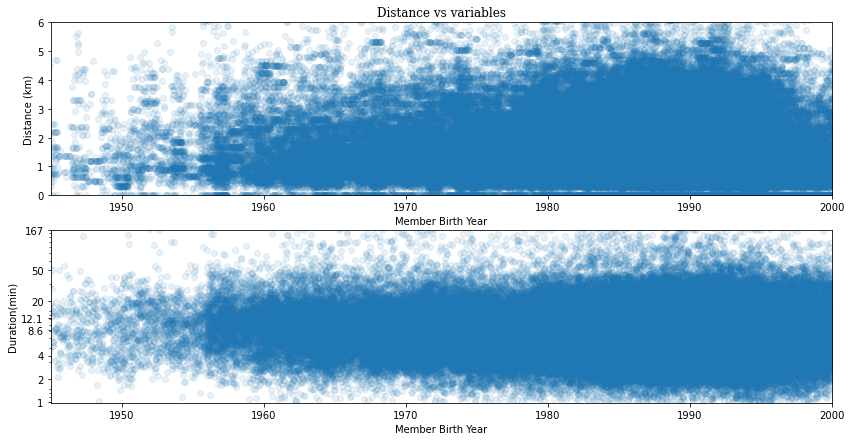

In [50]:
plt.figure(figsize = [14, 7])
plt.subplot(2, 1, 1)

plt.title('Distance vs variables', fontdict = font, loc = 'center');

sb.regplot(x = df.member_birth_year, 
           y = df.distance_km, 
           fit_reg = False, 
           x_jitter = 0.5,
           scatter_kws = {'alpha':1/10});

plt.xlim(1945,2000)
plt.ylim(0,6)

ylabel = df.duration_sec.describe()[3:7].values
ylabel = ylabel.astype(int)
plt.xlabel('Member Birth Year')
plt.ylabel('Distance (km)')


plt.subplot(2, 1, 2)

sb.regplot(x = df.member_birth_year, 
           y = df.duration_sec, 
           fit_reg = False, 
           x_jitter = 1,
           scatter_kws = {'alpha':1/10});

plt.yscale('log')

plt.xlim(1945,2000)
plt.ylim(59,10000)

# ylabel = df.duration_sec.describe()[3:7].values
# ylabel = ylabel.astype(int)

plt.yticks([60, 120, 240, 514, 726, 1200, 3000, 10000], [1, 2, 4, 8.6, 12.1, 20, 50, 167])
plt.xlabel('Member Birth Year')
plt.ylabel('Duration(min)')

plt.show()

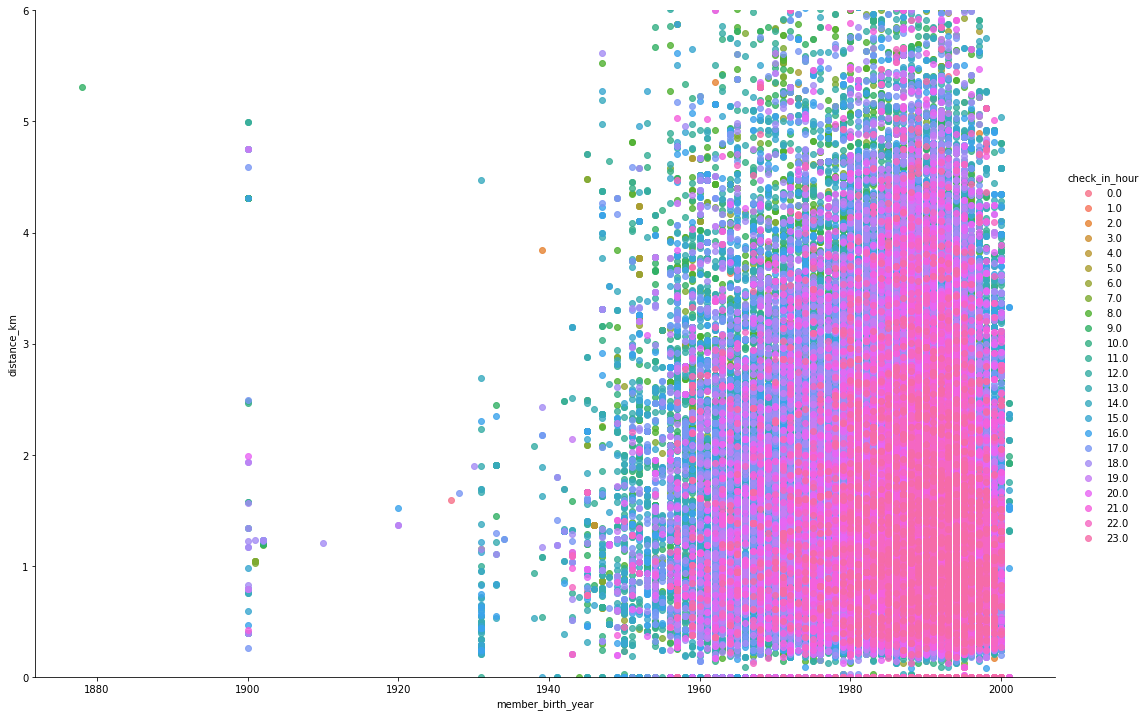

In [51]:
g = sb.FacetGrid(data = df, hue = 'check_in_hour', height = 10, aspect = 1.5)
g.map(sb.regplot, 'member_birth_year', 'distance_km', fit_reg = False)
plt.ylim(0,6)
g.add_legend();

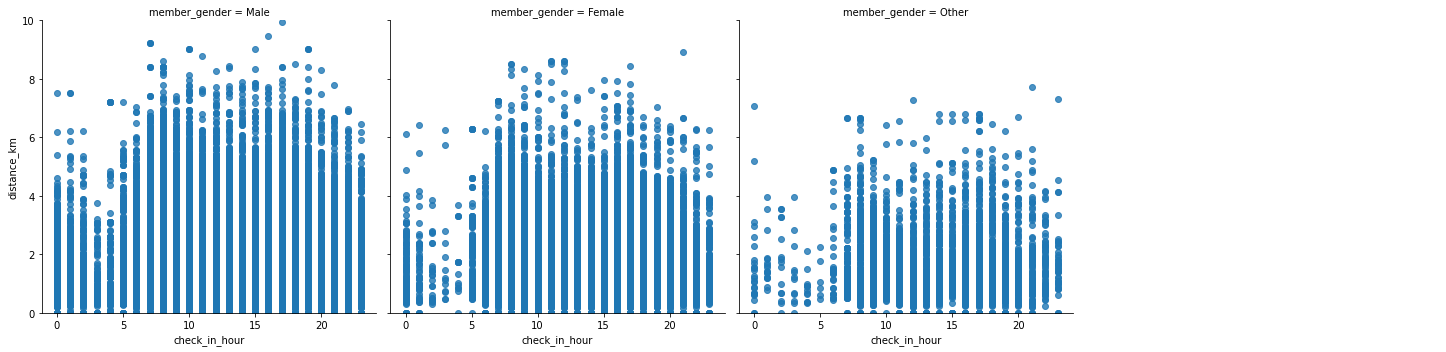

In [52]:
g = sb.FacetGrid(data = df, col = 'member_gender', col_wrap = 4, height = 5)
g.map(sb.regplot, 'check_in_hour', 'distance_km', fit_reg = False)
plt.ylim(0,10)

g.add_legend();

plt.show()

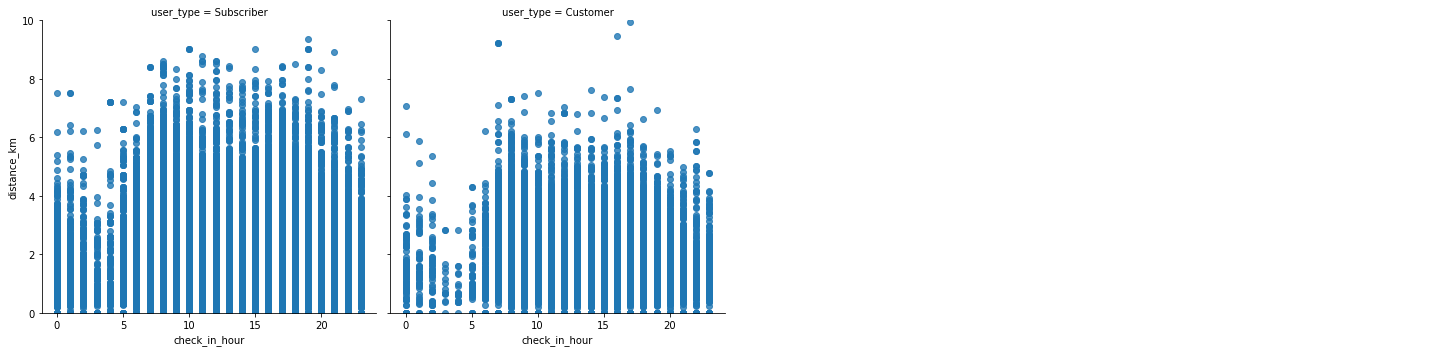

In [53]:
g = sb.FacetGrid(data = df, col = 'user_type', col_wrap = 4, height = 5)
g.map(sb.regplot, 'check_in_hour', 'distance_km', fit_reg = False)
plt.ylim(0,10)

g.add_legend();

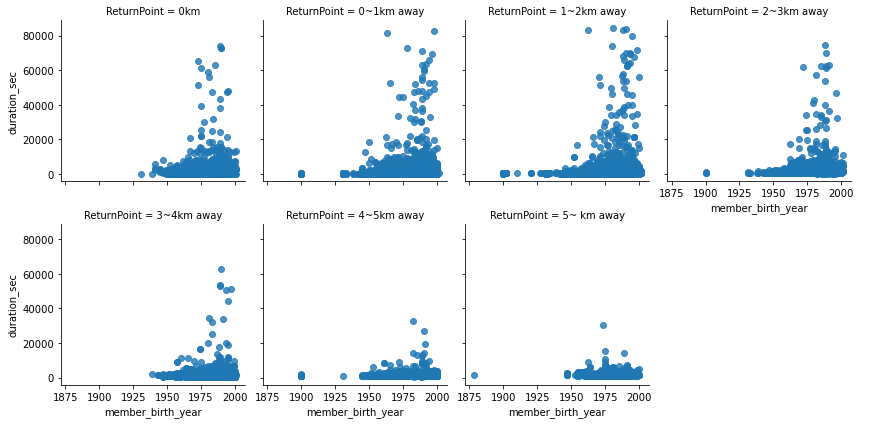

In [54]:
g = sb.FacetGrid(data = df, col = 'ReturnPoint', col_wrap = 4, height = 3)
g.map(sb.regplot, 'member_birth_year', 'duration_sec', fit_reg = False)
g.add_legend();

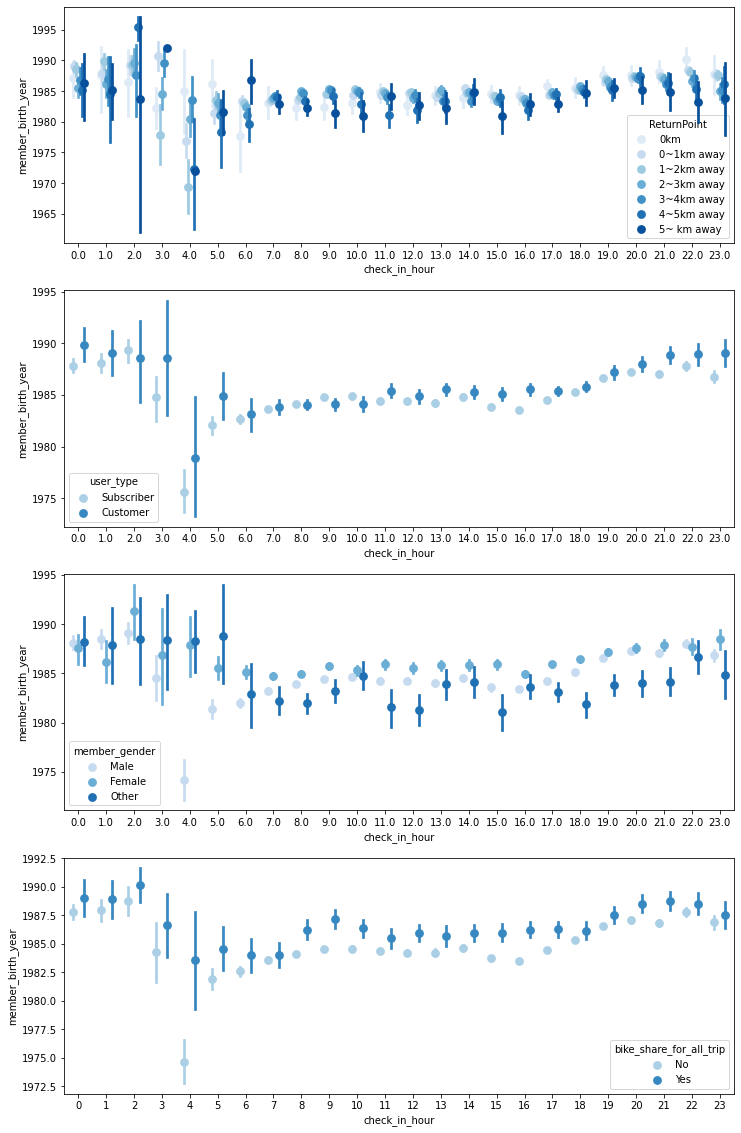

In [55]:
fig, ax = plt.subplots(nrows = 4, figsize = [12,20])

sb.pointplot(data = df, x = 'check_in_hour', y = 'member_birth_year', hue = 'ReturnPoint',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[0])
plt.xticks(range(0,24,1), range(0,24,1))

sb.pointplot(data = df, x = 'check_in_hour', y = 'member_birth_year', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[1])
plt.xticks(range(0,24,1), range(0,24,1))

sb.pointplot(data = df, x = 'check_in_hour', y = 'member_birth_year', hue = 'member_gender',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[2])
plt.xticks(range(0,24,1), range(0,24,1))

sb.pointplot(data = df, x = 'check_in_hour', y = 'member_birth_year', hue = 'bike_share_for_all_trip',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[3])
plt.xticks(range(0,24,1), range(0,24,1))

plt.show();

## Additional understandings

Most users are younger than the mid-'30s; however, the older age group starts occupying the ratio after 4 a.m., primarily non-subscribers.  

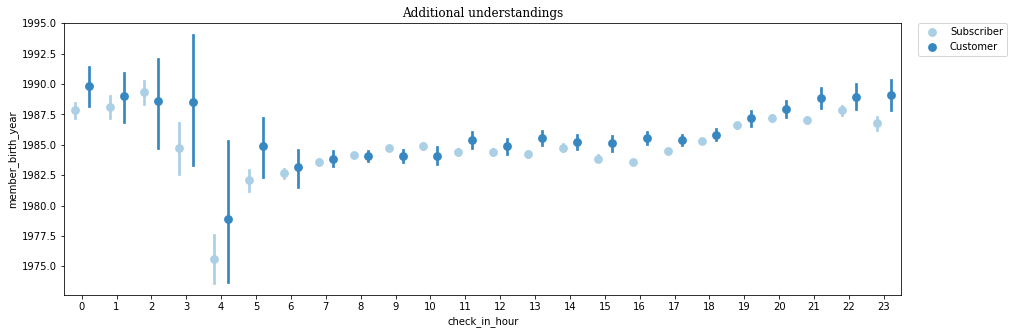

In [56]:
plt.figure(figsize = [15,5])

plt.title('Additional understandings', fontdict = font, loc = 'center');

sb.pointplot(data = df, x = 'check_in_hour', y = 'member_birth_year', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.xticks(range(0,24,1), range(0,24,1))
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)

plt.show()

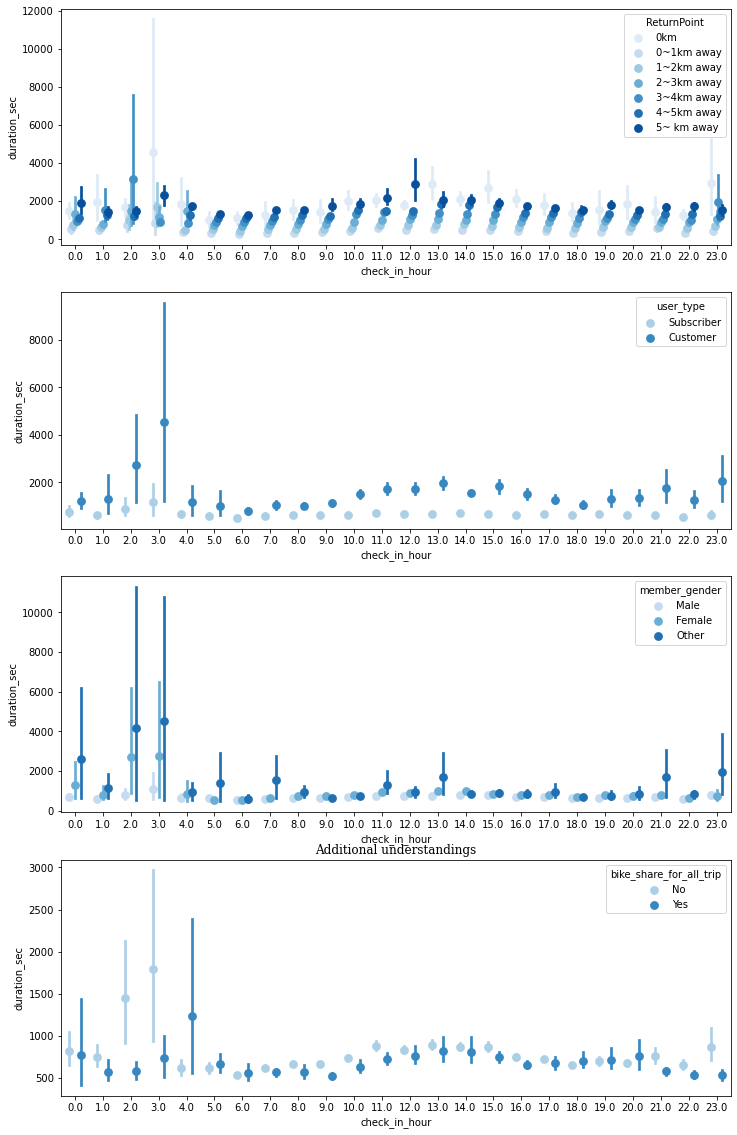

In [57]:
fig, ax = plt.subplots(nrows = 4, figsize = [12,20])

plt.title('Additional understandings', fontdict = font, loc = 'center');

sb.pointplot(data = df, x = 'check_in_hour', y = 'duration_sec', hue = 'ReturnPoint',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[0])

sb.pointplot(data = df, x = 'check_in_hour', y = 'duration_sec', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[1])

sb.pointplot(data = df, x = 'check_in_hour', y = 'duration_sec', hue = 'member_gender',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[2])

sb.pointplot(data = df, x = 'check_in_hour', y = 'duration_sec', hue = 'bike_share_for_all_trip',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[3])

plt.show();

It is most difficult to predict for users who checked in between 2 a.m. and 4 a.m. how long the users will use bikes and how far away they will check out; however, they are primarily non-subscribing mixed-genders.

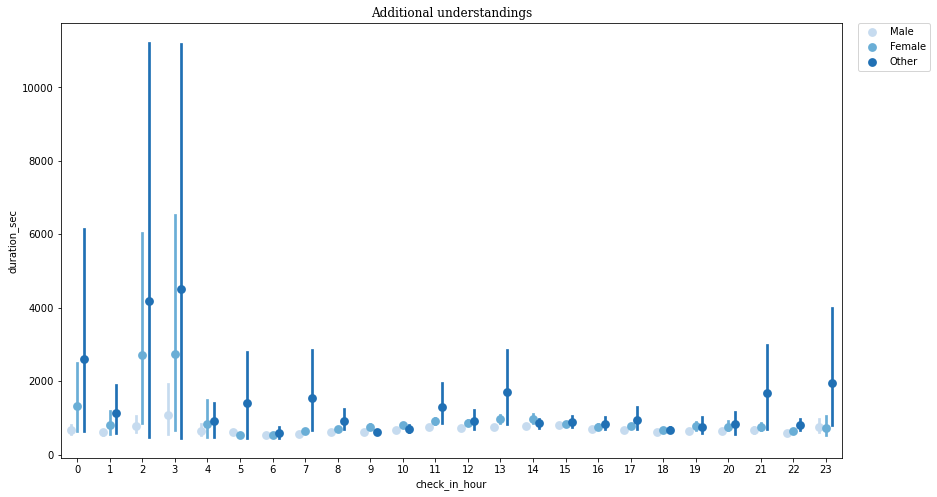

In [58]:
plt.figure(figsize = [14,8])

plt.title('Additional understandings', fontdict = font, loc = 'center');

sb.pointplot(data = df, x = 'check_in_hour', y = 'duration_sec', hue = 'member_gender',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.xticks(range(0,24,1), range(0,24,1))
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)

plt.show()

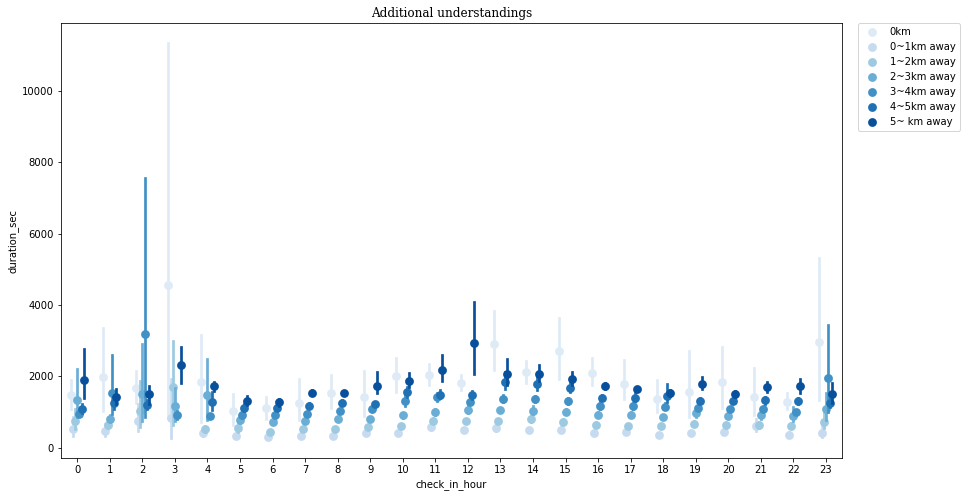

In [59]:
plt.figure(figsize = [14,8])

plt.title('Additional understandings', fontdict = font, loc = 'center');

sb.pointplot(data = df, x = 'check_in_hour', y = 'duration_sec', hue = 'ReturnPoint',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.xticks(range(0,24,1), range(0,24,1))
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)

plt.show()

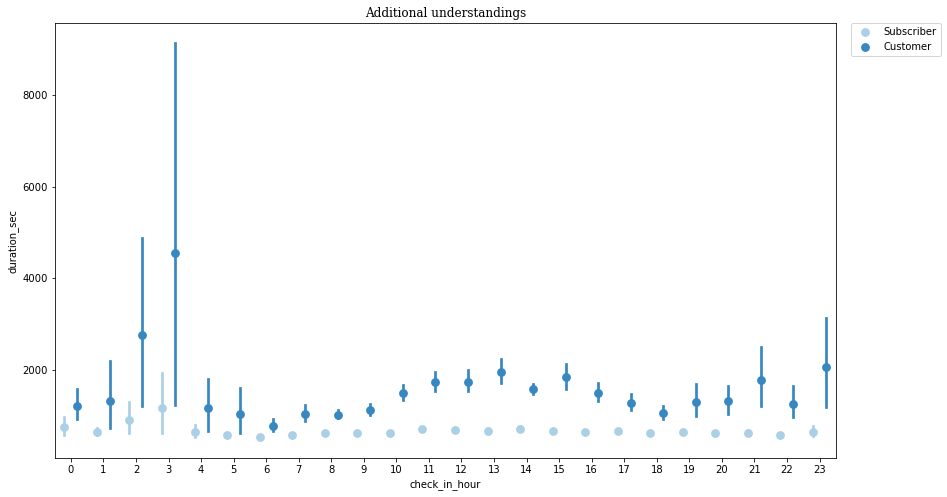

In [60]:
plt.figure(figsize = [14,8])

plt.title('Additional understandings', fontdict = font, loc = 'center');


sb.pointplot(data = df, x = 'check_in_hour', y = 'duration_sec', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4)
plt.xticks(range(0,24,1), range(0,24,1))
plt.legend(bbox_to_anchor=(1.02,1),loc = 'upper left', borderaxespad=0)

plt.show()

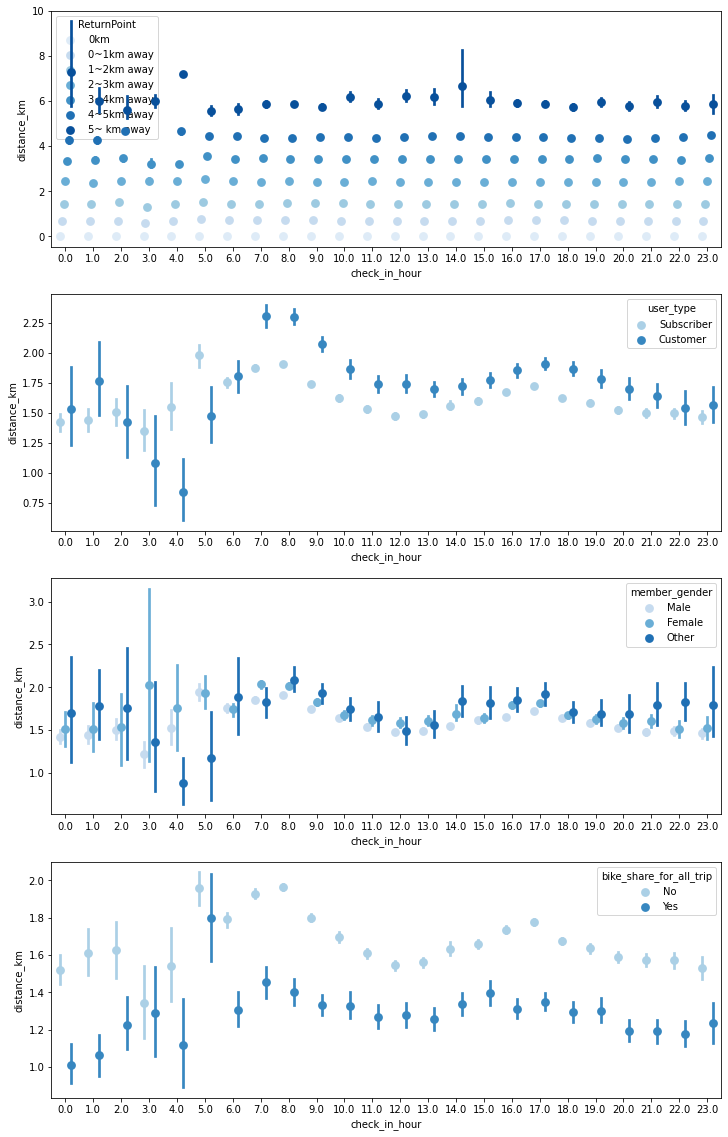

In [61]:
fig, ax = plt.subplots(nrows = 4, figsize = [12,20])

sb.pointplot(data = df, x = 'check_in_hour', y = 'distance_km', hue = 'ReturnPoint',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[0])

sb.pointplot(data = df, x = 'check_in_hour', y = 'distance_km', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[1])

sb.pointplot(data = df, x = 'check_in_hour', y = 'distance_km', hue = 'member_gender',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[2])

sb.pointplot(data = df, x = 'check_in_hour', y = 'distance_km', hue = 'bike_share_for_all_trip',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[3])

plt.show();

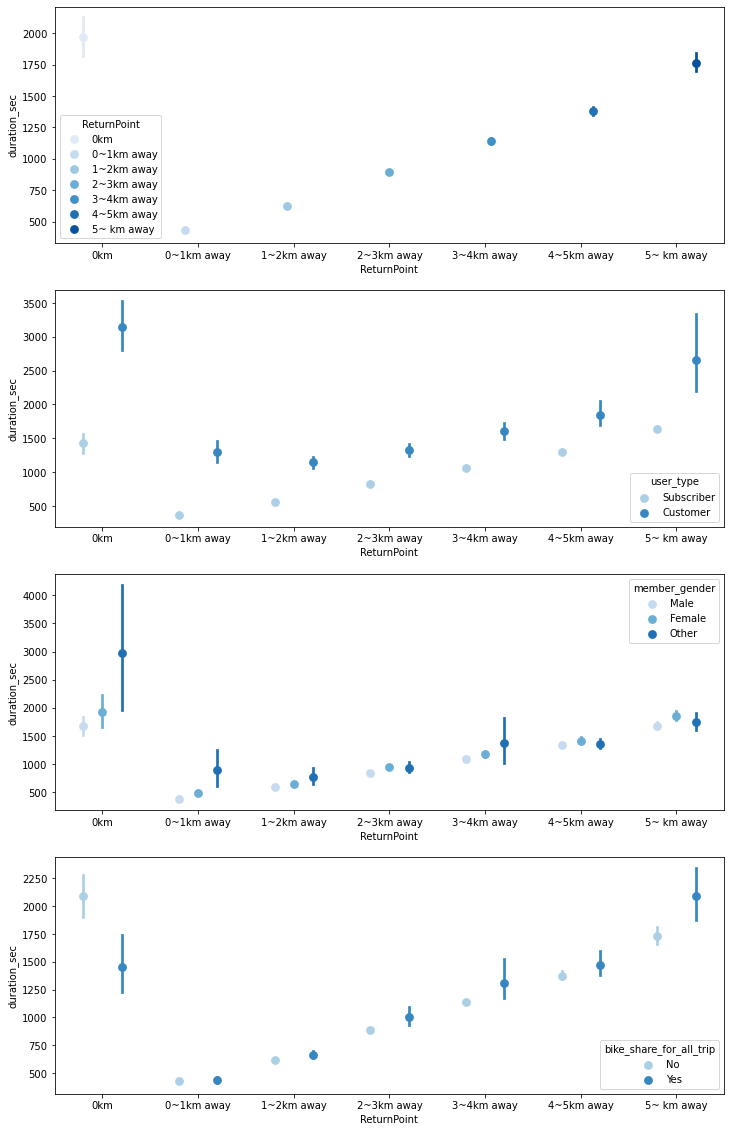

In [62]:
fig, ax = plt.subplots(nrows = 4, figsize = [12,20])

sb.pointplot(data = df, x = 'ReturnPoint', y = 'duration_sec', hue = 'ReturnPoint',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[0])

sb.pointplot(data = df, x = 'ReturnPoint', y = 'duration_sec', hue = 'user_type',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[1])

sb.pointplot(data = df, x = 'ReturnPoint', y = 'duration_sec', hue = 'member_gender',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[2])

sb.pointplot(data = df, x = 'ReturnPoint', y = 'duration_sec', hue = 'bike_share_for_all_trip',
           palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[3])

plt.show();

## Recommedation

The subscribers less used the bike than non-subscribers, which is probably a vital marketing point because we can increase the profit margin, revenue minus cost, with the membership contract. Although we figured out there are fewer users during the weekends, but they used more time. With these findings, we possibly recommend last-In bikes(high-tier inventory) to first-Out(serve) to weekend users with premium memberships.

In [65]:
#!jupyter nbconvert Project_Slide_deck_FordGoBikeSystem.ipynb --to slides --post serve --no-input --no-prompt